### Binary classification of brain tumor MR image series

W tym modelu tworzone są serie 4 obrazów MR mózgu posiadające różne rodzaje nowotworu i zdrowe (nazwałem te obrazy "helthy" i "sick"). Dane nie są zbalansowane.  Zadaniem jest klasyfikacja całej serii czterech obrazów. Serie tworzone są w sposób sztuczny, poprzez grupowanie czterech obrazów chorych lub zdrowych.
Dane pochodzą z https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

Klasyfikacja dokonywana jest za pomocą pretrenowanej sieci Xception, wyniki są zbierane w jeden wektor za pomocą warstwy layers.TimeDistributed i potem layers.GlobalAveragePooling1D() oraz GlobalMaxPooling1D. Można zastosować także tylko jeden z typów pooling lub wogóle zrezygnować z pooling i użyć wszystkich zmiennych wyjściowych z czterech sieci Xception używając funkcji flatten. Celem uniknięcia przetrenowania zastosowano augmentację danych poprzez dodanie warstw augmentacji przed wejściem sieci Xception.



Listopad 2025, Marcin Wolter i claude.ai :)


In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress warnings

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from PIL import Image

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.17.0


### Import brain tumor data from kaggle





The Kaggle API needs authentication. Here's how to fix it:
Option 1: Set up Kaggle API credentials
Step 1: Get your API token

Go to https://www.kaggle.com/settings/account
Scroll to "API" section
Click "Create New API Token"
This downloads kaggle.json

Step 2: Place the credentials file
bash# Create kaggle directory
mkdir -p ~/.kaggle

# Move the downloaded file
mv ~/Downloads/kaggle.json ~/.kaggle/

# Set permissions
chmod 600 ~/.kaggle/kaggle.json
Step 3: Now download
kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
unzip brain-tumor-mri-dataset.zip

or download manually:
Go to: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
Click the download button on the right side
Save and extract the zip file

In [6]:

# Install kaggle
#! pip install kaggle

# Set up Kaggle API credentials (download kaggle.json from kaggle.com/account)
# Place it in ~/.kaggle/kaggle.json (Linux/Mac) or C:\Users\YourName\.kaggle\kaggle.json (Windows)

# Download dataset
#! kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
#! unzip brain-tumor-mri-dataset.zip



In [7]:
IMAGES_PER_SERIES = 4  # Number of images in each series (e.g., 4 different angles)
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

In [8]:
# ============================================
# Step 1: Load Real MRI Data
# ============================================
print("Loading Brain Tumor MRI dataset...")

# Dataset paths - adjust to your extraction location
DATA_DIR = './brain-tumor-mri-dataset/Training'  # or './Testing' for test set
CATEGORIES = {
    'notumor': 0,  # Healthy
    'glioma': 1,   # Sick (tumor type 1)
    'meningioma': 1,  # Sick (tumor type 2)
    'pituitary': 1   # Sick (tumor type 3)
}

# For binary classification: notumor vs any tumor
BINARY_CATEGORIES = {
    'notumor': 0,
    'glioma': 1,
    'meningioma': 1,
    'pituitary': 1
}


Loading Brain Tumor MRI dataset...


In [9]:

def load_mri_series(data_dir, images_per_series=4, max_series_per_class=500):
    """
    Load MRI images and group them into series.
    Since each patient may not have exactly IMAGES_PER_SERIES scans,
    we create artificial series by grouping consecutive images.
    
    Args:
        data_dir: Path to data directory
        images_per_series: Number of images per series
        max_series_per_class: Maximum number of series to load per class
    
    Returns:
        X: Array of image series (num_series, images_per_series, height, width, channels)
        y: Array of labels (num_series,)
    """
    all_series = []
    all_labels = []
    
    for category, label in BINARY_CATEGORIES.items():
        category_path = os.path.join(data_dir, category)
        
        if not os.path.exists(category_path):
            print(f"Warning: {category_path} not found, skipping...")
            continue
        
        # Get all image files
        image_files = [f for f in os.listdir(category_path) 
                      if f.endswith(('.jpg', '.png', '.jpeg'))]
        image_files.sort()  # Sort for consistency
        
        print(f"Found {len(image_files)} images in {category}")
        
        # Group images into series
        series_count = 0
        for i in range(0, len(image_files) - images_per_series + 1, images_per_series):
            if series_count >= max_series_per_class:
                break
            
            series = []
            valid_series = True
            
            for j in range(images_per_series):
                img_path = os.path.join(category_path, image_files[i + j])
                
                try:
                    # Load and preprocess image
                    img = Image.open(img_path).convert('RGB')
                    img = img.resize((IMG_HEIGHT, IMG_WIDTH))
                    img_array = np.array(img) / 255.0  # Normalize to [0, 1]
                    series.append(img_array)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
                    valid_series = False
                    break
            
            if valid_series and len(series) == images_per_series:
                all_series.append(np.array(series))
                all_labels.append(label)
                series_count += 1
        
        print(f"Created {series_count} series from {category}")
    
    X = np.array(all_series)
    y = np.array(all_labels)
    
    return X, y

# Load the data
X, y = load_mri_series(DATA_DIR, images_per_series=IMAGES_PER_SERIES, max_series_per_class=500)

print(f"\nLoaded data shape: {X.shape}")  # (num_series, 4, 224, 224, 3)
print(f"Labels shape: {y.shape}")  # (num_series,)
print(f"Unique labels: {np.unique(y)}")
print(f"Label distribution: Healthy (0): {np.sum(y == 0)}, Tumor (1): {np.sum(y == 1)}")


Found 1595 images in notumor
Created 398 series from notumor
Found 1321 images in glioma
Created 330 series from glioma
Found 1339 images in meningioma
Created 334 series from meningioma
Found 1457 images in pituitary
Created 364 series from pituitary

Loaded data shape: (1426, 4, 224, 224, 3)
Labels shape: (1426,)
Unique labels: [0 1]
Label distribution: Healthy (0): 398, Tumor (1): 1028



Visualizing generated data...
(1426, 4, 224, 224, 3) (1426,)

Generated data visualization saved as 'generated_data_visualization.png'


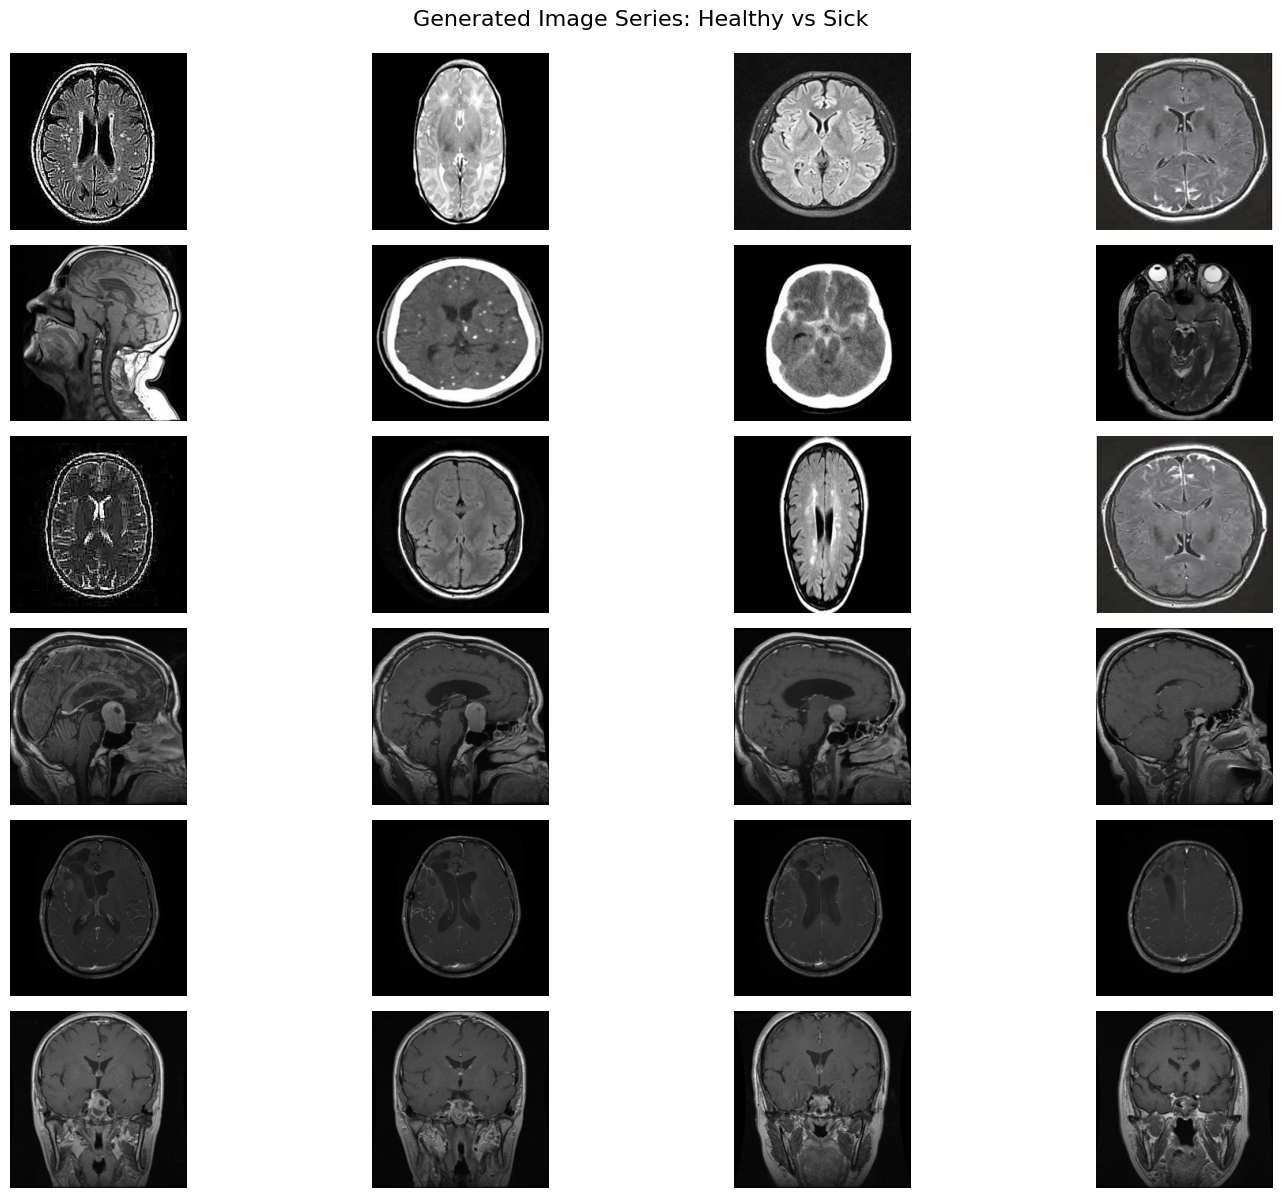

In [22]:
# ============================================
# Visualize Generated Data
# ============================================
def visualize_generated_series(healthy_data, sick_data, num_series=3):
    """
    Display sample series from both healthy and sick categories.
    
    Args:
        healthy_data: Array of healthy image series
        sick_data: Array of sick image series
        num_series: Number of series to display from each category
    """
    fig, axes = plt.subplots(num_series * 2, IMAGES_PER_SERIES, 
                             figsize=(16, 4 * num_series))
    fig.suptitle('Generated Image Series: Healthy vs Sick', fontsize=16, y=0.995)
    
    # Display healthy series
    for k in range(num_series):
        i = np.random.randint(0, healthy_data.shape[0])
        for j in range(IMAGES_PER_SERIES):
            ax = axes[k, j]
            ax.imshow(healthy_data[i, j])
            ax.axis('off')
            if j == 0:
                ax.set_ylabel(f'Healthy\nSeries {i+1}', 
                            fontsize=12, rotation=0, 
                            labelpad=50, va='center')
            if i == 0:
                ax.set_title(f'Image {j+1}', fontsize=11)
    
    # Display sick series
    for k in range(num_series):
        i = np.random.randint(0, sick_data.shape[0])
        for j in range(IMAGES_PER_SERIES):
            ax = axes[num_series + k, j]
            ax.imshow(sick_data[i, j])
            ax.axis('off')
            if j == 0:
                ax.set_ylabel(f'Sick\nSeries {i+1}', 
                            fontsize=12, rotation=0, 
                            labelpad=50, va='center', 
                            color='red')
            if i == 0 and num_series == 0:
                ax.set_title(f'Image {j+1}', fontsize=11)
    
    plt.tight_layout()
    plt.savefig('generated_data_visualization.png', dpi=300, bbox_inches='tight')
    print("\nGenerated data visualization saved as 'generated_data_visualization.png'")
    plt.show()

print("\nVisualizing generated data...")

print(X.shape, y.shape)
sick_mask = y == 1
healthy_mask = y == 0 
visualize_generated_series(X[healthy_mask], X[sick_mask], num_series=3)


In [13]:

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True
)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

Training samples: 1140, Test samples: 286


In [14]:
# Calculate class weights to handle any imbalance
# We have no imbalance here, just for the future use.
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")

Class weights: {0: 1.7924528301886793, 1: 0.6934306569343066}


In [15]:
# ============================================
# Step 2: Build the Model
# ============================================

def create_series_classifier():
    """
    Use ResNet50 as frozen feature extractor, train only the classification head.
    """
    
    # Input: series of images
    series_input = layers.Input(shape=(IMAGES_PER_SERIES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    # Moderate augmentation
    data_augmentation = keras.Sequential([
        layers.RandomRotation(0.15),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomZoom(0.1),
        layers.RandomFlip("horizontal"),
        layers.RandomFlip("vertical"),
    ])
    
    # Apply augmentation
    augmented = layers.TimeDistributed(data_augmentation)(series_input)
    
    # Load pretrained Xception - COMPLETELY FROZEN
    #base_model = keras.applications.ResNet50( # I had problems with ResNet50, Xception works better
    base_model = keras.applications.Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
        pooling='avg'
    )
    
    # Freeze ALL layers
    base_model.trainable = False
    
    # Process each image with Xception
    features = layers.TimeDistributed(base_model)(augmented)
    
    # Aggregate features across the series - use BOTH avg and max
    avg_features = layers.GlobalAveragePooling1D()(features)
    max_features = layers.GlobalMaxPooling1D()(features)
    combined = layers.Concatenate()([avg_features, max_features])
    
    # Moderate classification head
    x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(combined)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = layers.Dropout(0.4)(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=series_input, outputs=output)
    
    return model

In [16]:

print("\nBuilding model...")
model = create_series_classifier()
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),  # low learning rate
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

# Add learning rate reduction callback
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.000001,
    verbose=1
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10, 
    restore_best_weights=True
)

# Add after early_stopping callback definition
class PredictionMonitor(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            preds = self.model.predict(X_train[:20], verbose=0)
            pred_labels = (preds > 0.5).astype(int).flatten()
            true_labels = y_train[:20]
            print(f"\nEpoch {epoch} - Sample predictions: {pred_labels[:10]}")
            print(f"Epoch {epoch} - True labels:        {true_labels[:10]}")
            #print(f"Epoch {epoch} - Prediction mean: {preds.mean():.3f}")

prediction_monitor = PredictionMonitor()

# Update callbacks
#callbacks=[reduce_lr, prediction_monitor]




Building model...


I0000 00:00:1762769119.254661 2292837 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1762769119.286978 2292837 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1762769119.288317 2292837 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1762769119.291631 2292837 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 4, 224,    │          0 │ -                 │
│ (InputLayer)        │ 224, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 4, 224,    │          0 │ input_layer[0][0] │
│ (TimeDistributed)   │ 224, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 4, 2048)   │ 20,861,480 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ time_distributed… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 2048)      │          0 │ time_distributed… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4096)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    524,416 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,394,729 (81.61 MB)

 Trainable params: 532,993 (2.03 MB)

 Non-trainable params: 20,861,736 (79.58 MB)

In [17]:

# ============================================
# Step 3: Train the Model
# ============================================
print("\nTraining model...")



history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    #validation_split=0.2,
    epochs=200,  # More epochs
    batch_size=16,  # Larger batch size
    class_weight=class_weight_dict,
    callbacks=[reduce_lr, prediction_monitor, early_stopping],
    verbose=1
)



Training model...
Epoch 1/200


W0000 00:00:1762769133.947681 2293114 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762769133.980578 2293114 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762769133.981142 2293114 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762769133.985949 2293114 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762769133.987077 2293114 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762769133.988357 2293114 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762769133.989771 2293114 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762769133.990366 2293114 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762769133.990967 2293114 gp

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.6620 - auc: 0.6421 - loss: 1.1387

W0000 00:00:1762769142.443202 2293111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762769142.443695 2293111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762769142.444122 2293111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762769142.444595 2293111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762769142.445046 2293111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762769142.445491 2293111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762769142.445931 2293111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762769142.446381 2293111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762769142.446830 2293111 gp


Epoch 0 - Sample predictions: [1 0 1 1 0 1 0 0 1 0]
Epoch 0 - True labels:        [1 0 1 1 1 1 0 1 0 0]
72/72 ━━━━━━━━━━━━━━━━━━━━ 24s 193ms/step - accuracy: 0.6625 - auc: 0.6432 - loss: 1.1372 - val_accuracy: 0.9161 - val_auc: 0.9589 - val_loss: 0.8137 - learning_rate: 1.0000e-05
Epoch 2/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 0.7864 - auc: 0.8451 - loss: 0.8279 - val_accuracy: 0.9196 - val_auc: 0.9745 - val_loss: 0.7037 - learning_rate: 1.0000e-05
Epoch 3/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.8200 - auc: 0.8913 - loss: 0.7491 - val_accuracy: 0.9196 - val_auc: 0.9789 - val_loss: 0.6271 - learning_rate: 1.0000e-05
Epoch 4/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.8181 - auc: 0.9129 - loss: 0.7205 - val_accuracy: 0.9231 - val_auc: 0.9819 - val_loss: 0.5778 - learning_rate: 1.0000e-05
Epoch 5/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.8579 - auc: 0.9509 - loss: 0.6303 - val_accuracy: 0.9371 - val_auc: 0.9832 - val_lo

In [18]:

# ============================================
# Step 4: Evaluate the Model
# ============================================
print("\nEvaluating model...")

# Predictions
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Healthy', 'Sick']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Test accuracy
test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Train accuracy
train_loss, train_acc, train_auc = model.evaluate(X_train, y_train, verbose=0)
print(f"\nTrain Accuracy: {train_acc:.4f}")
print(f"Train AUC: {train_auc:.4f}")




Evaluating model...


W0000 00:00:1762770943.232011 2293107 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762770943.232683 2293107 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762770943.233255 2293107 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762770943.233854 2293107 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762770943.234439 2293107 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762770943.235033 2293107 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762770943.235619 2293107 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762770943.236370 2293107 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762770943.237117 2293107 gp

1/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step

W0000 00:00:1762770943.433333 2293107 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762770943.434150 2293107 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762770943.434776 2293107 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762770943.435406 2293107 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762770943.436052 2293107 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762770943.436686 2293107 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762770943.437501 2293107 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762770943.438186 2293107 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762770943.438906 2293107 gp

8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step

W0000 00:00:1762770944.626375 2293107 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762770944.626971 2293107 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762770944.627516 2293107 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762770944.628063 2293107 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762770944.628609 2293107 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762770944.629153 2293107 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762770944.629699 2293107 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762770944.630428 2293107 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762770944.631155 2293107 gp

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step


W0000 00:00:1762770944.828477 2293107 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762770944.829165 2293107 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762770944.838676 2293107 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762770944.847665 2293107 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762770944.848213 2293107 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762770944.848763 2293107 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762770944.849321 2293107 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762770944.849904 2293107 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762770944.850540 2293107 gp


Classification Report:
              precision    recall  f1-score   support

     Healthy       0.96      0.97      0.97        80
        Sick       0.99      0.99      0.99       206

    accuracy                           0.98       286
   macro avg       0.98      0.98      0.98       286
weighted avg       0.98      0.98      0.98       286


Confusion Matrix:
[[ 78   2]
 [  3 203]]

Test Accuracy: 0.9825
Test AUC: 0.9993

Train Accuracy: 0.9930
Train AUC: 0.9999


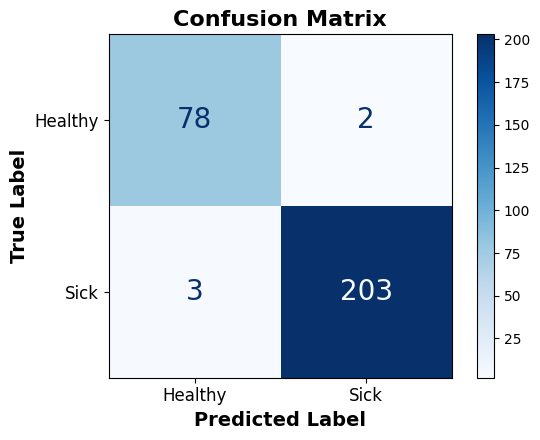

In [19]:
# Create and plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 4.5))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, 
    display_labels=['Healthy', 'Sick'],
    cmap='Blues',
    ax=ax,
    colorbar=True
)

# Customize font sizes
ax.set_xlabel('Predicted Label', fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=14, fontweight='bold')
ax.set_title('Confusion Matrix', fontsize=16, fontweight='bold')
ax.tick_params(axis='both', labelsize=12)

# Make the numbers in cells bigger
for text in ax.texts:
    text.set_fontsize(20)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


Training history saved as 'training_history.png'


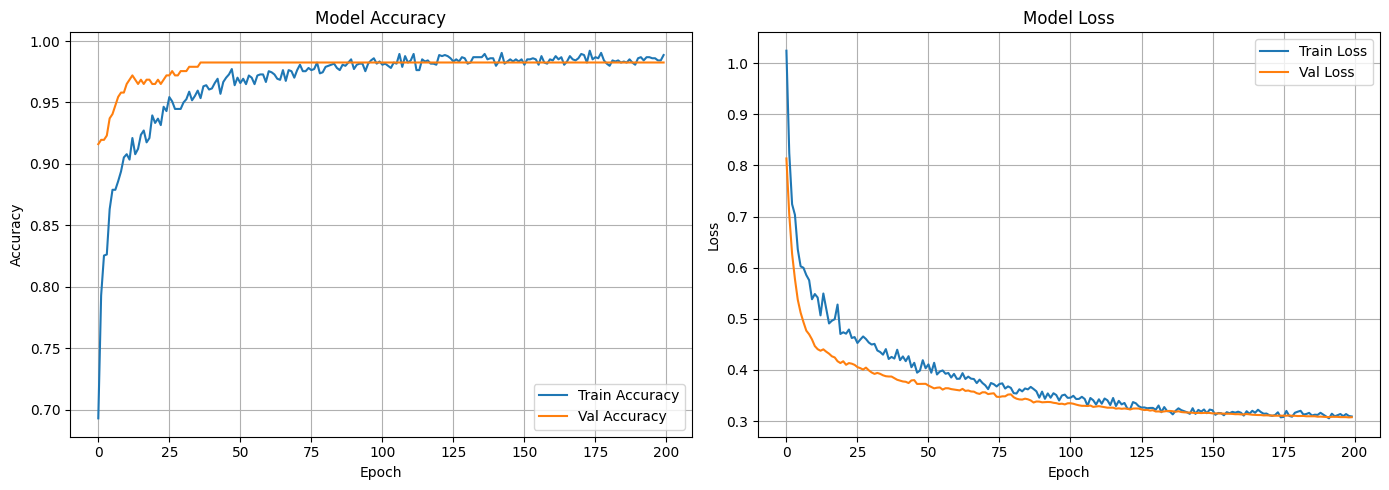

Sample predictions saved as 'sample_predictions.png'


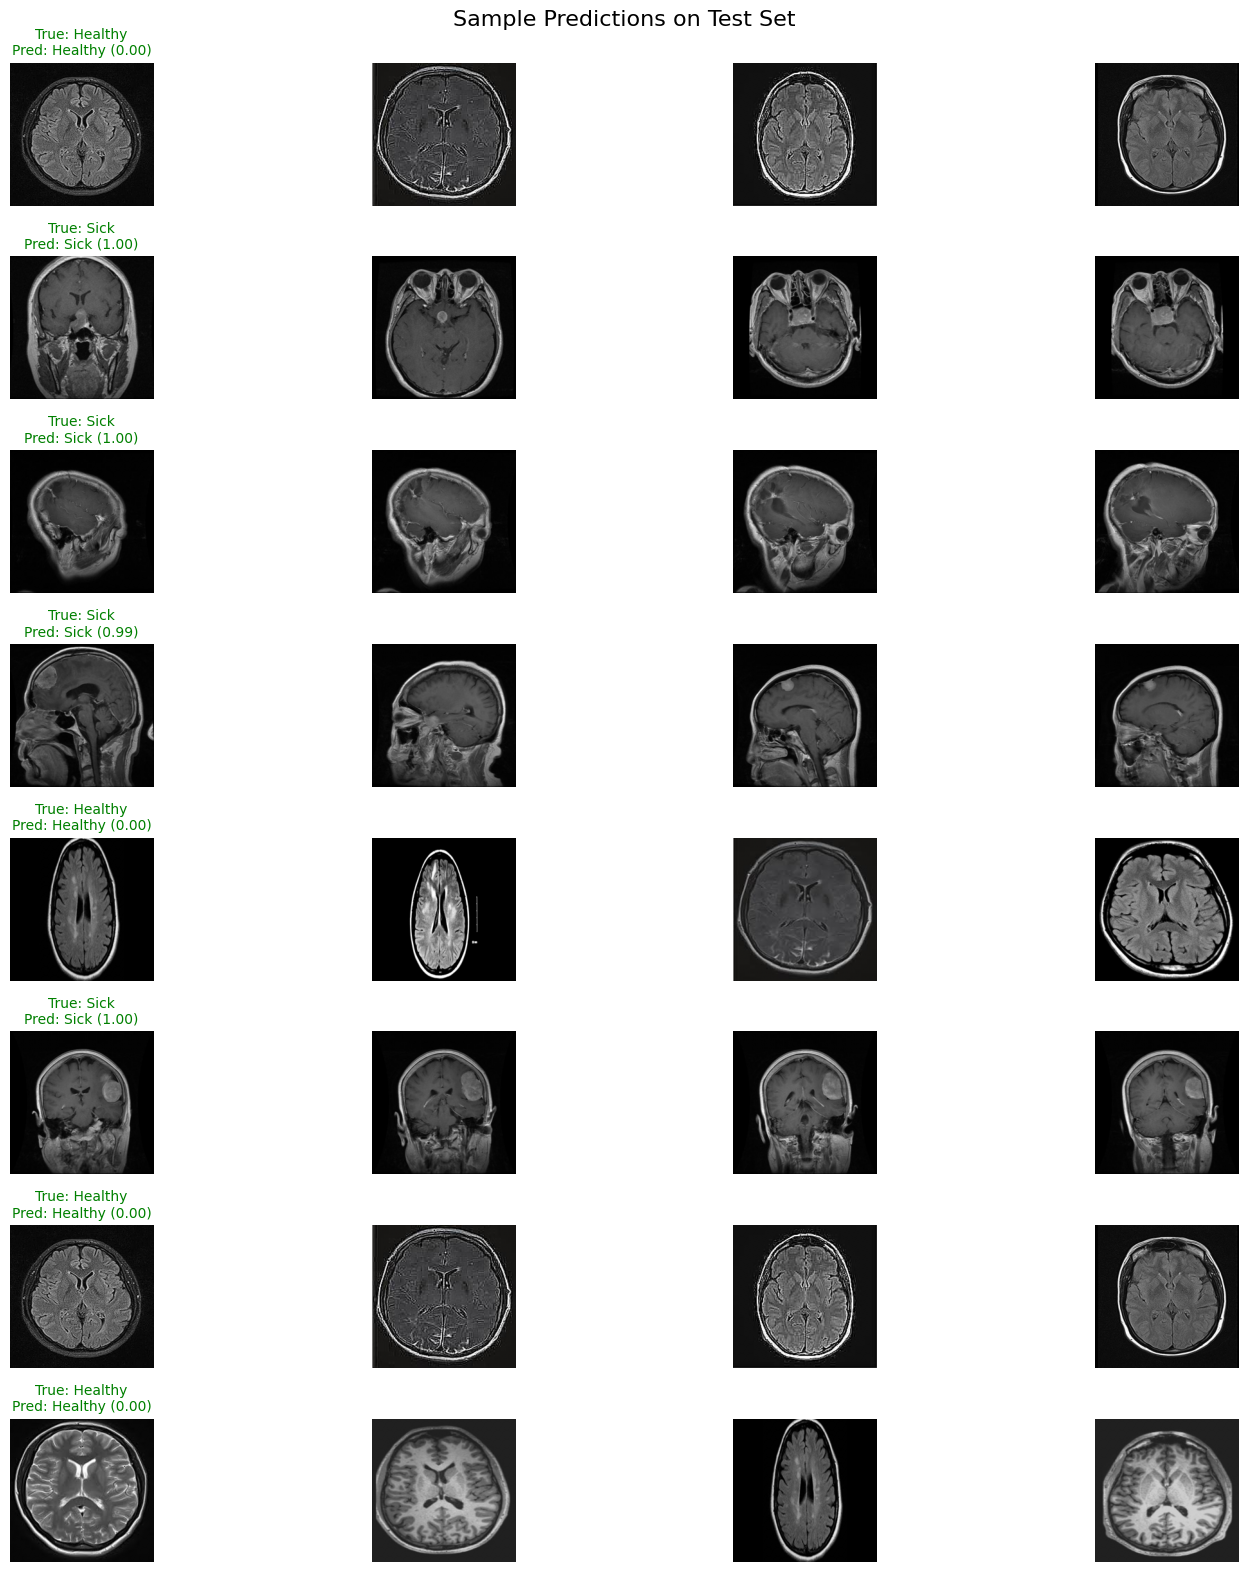


Model training and evaluation complete!


In [20]:

# ============================================
# Step 5: Visualize Results
# ============================================
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
print("\nTraining history saved as 'training_history.png'")
plt.show()

# Visualize sample predictions
nrows = 8
fig, axes = plt.subplots(nrows, 4, figsize=(16, 16))
fig.suptitle('Sample Predictions on Test Set', fontsize=16)

for i in range(nrows):
    sample_idx = np.random.randint(0, len(X_test))
    series = X_test[sample_idx]
    true_label = y_test[sample_idx]
    pred_proba = y_pred_proba[sample_idx][0]
    pred_label = int(pred_proba > 0.5)
    
    for j in range(4):
        axes[i, j].imshow(series[j])
        axes[i, j].axis('off')
        if j == 0:
            color = 'green' if pred_label == true_label else 'red'
            axes[i, j].set_title(
                f"True: {'Sick' if true_label == 1 else 'Healthy'}\n"
                f"Pred: {'Sick' if pred_label == 1 else 'Healthy'} ({pred_proba:.2f})",
                color=color, fontsize=10
            )

plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
print("Sample predictions saved as 'sample_predictions.png'")
plt.show()

print("\n" + "="*50)
print("Model training and evaluation complete!")
print("="*50)